# GPU

# Packages

In [3]:
import math
import sys
from cupy.cuda import curand
from mpi4py import MPI
from numba import cuda, vectorize, njit, prange
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

# Functions and Variables

In [59]:
# Temperature
temp = 3.0
inv_temp = 1/temp # inverse temperature
inv_temp_sq = inv_temp*inv_temp # squared inverse temperature

# Parameters
J= 1.0 # Interaction constant
h= 0.0 # external magnetic field

# Setup MPI and get neighbor ranks
comm = MPI.COMM_WORLD
rank = comm.rank
rank_up = comm.rank - 1 if (comm.rank - 1 >= 0) else comm.size - 1
rank_down = comm.rank + 1 if (comm.rank + 1 < comm.size) else 0

# Lattice Size
lattice_n = 512
lattice_m = lattice_n

# No. of Steps
eq_steps = 10_000  # equlibration steps
mc_steps = 10_000 # monte carlo steps

# For calculation of the mean of observables:
n1 = 1.0/(mc_steps*lattice_n*lattice_m)
n2 = 1.0/(mc_steps*mc_steps*lattice_n*lattice_m)

# Random Seeds
seed = 1234
common_seed = 1234
use_common_seed = True

# Check arguments
if lattice_m % 2 != 0:
    raise Exception("lattice_m must be an even value. Aborting.")
if lattice_n % comm.size != 0:
    raise Exception("lattice_n must be evenly divisible by number of GPUs. Aborting.")
if (lattice_n / comm.size) % 2 != 0:
    raise Exception("Slab width (lattice_n / nGPUs) must be an even value. Aborting.")
    
# Compute slab width
lattice_slab_n = lattice_n // comm.size

# Generate lattice with random spins with shape of randval array
@vectorize(['int8(float32)'], target='cuda')                         
def generate_lattice(randval):
    return 1 if randval > 0.5 else -1 

@cuda.jit()
def update_lattice_multi(lattice, op_lattice, op_lattice_up, op_lattice_down, randvals, is_black):
    """
    Perform 1 Monte Carlo sweep using the checkerboard Metropolis algorithm using multiple GPU
    
    Parameters:
    -----------
    lattice: array
        The lattice to perform an MC sweep on
    op_lattice: array
        The opposite lattice corresponding to the neighbors of the lattice
    randvals: array
        Array containing float values to be used for the Metropolis criterion
    is_black: bool
        A boolean telling us what color is the lattice. If True, the array is the black lattice.
        If False, the array is the white lattice.
    inv_temp: float
        The inverse temperature of the system
    J: float
        Interaction constant
    h: float
        External magnetic field
    """
    
    n,m = lattice.shape
    tid = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    j = tid % m
    i = tid // m

    if (i >= n or j >= m): return

    # Set stencil indices with periodicity
    jpp = (j + 1) if (j + 1) < m else 0
    jnn = (j - 1) if (j - 1) >= 0 else (m - 1)

    # Select off-column index based on color and row index parity
    if (is_black):
        joff = jpp if (i % 2) else jnn
    else:
        joff = jnn if (i % 2) else jpp

    # Compute sum of nearest neighbor spins (taking values from neighboring
    # lattice slabs if required)
    nn_sum = op_lattice[i, j] + op_lattice[i, joff]
    nn_sum += op_lattice[i - 1, j] if (i - 1) >= 0 else op_lattice_up[n - 1, j]
    nn_sum += op_lattice[i + 1, j] if (i + 1) < n else op_lattice_down[0, j]

    # Determine whether to flip spin
    spin = lattice[i, j]
    delta_E = -2* spin*(J*nn_sum + h)
    acceptance_ratio = math.exp(delta_E*inv_temp)
    if delta_E >= 0:
        lattice[i, j] = -spin
    elif randvals[i, j] < acceptance_ratio:
        lattice[i, j] = -spin
        
@cuda.jit()
def update_lattice(lattice, op_lattice, randvals, is_black, inv_temp):
    """
    Perform 1 Monte Carlo sweep using the checkerboard Metropolis algorithm using a single GPU
    
    Parameters:
    -----------
    lattice: array
        The lattice to perform an MC sweep on
    op_lattice: array
        The opposite lattice corresponding to the neighbors of the lattice
    randvals: array
        Array containing float values to be used for the Metropolis criterion
    is_black: bool
        A boolean telling us what color is the lattice. If True, the array is the black lattice.
        If False, the array is the white lattice.
    inv_temp: float
        The inverse temperature of the system
    J: float
        Interaction constant
    h: float
        External magnetic field
    """
    
    n,m = lattice.shape
    tid = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    i = tid // m
    j = tid % m

    if (i >= n or j >= m): return

    # Set stencil indices with periodicity
    ipp = (i + 1) if (i + 1) < n else 0
    jpp = (j + 1) if (j + 1) < m else 0
    inn = (i - 1) if (i - 1) >= 0 else (n - 1)
    jnn = (j - 1) if (j - 1) >= 0 else (m - 1)

    # Select off-column index based on color and row index parity
    if (is_black):
        joff = jpp if (i % 2) else jnn
    else:
        joff = jnn if (i % 2) else jpp

    # Compute sum of nearest neighbor spins
    nn_sum = op_lattice[inn, j] + op_lattice[i, j] + op_lattice[ipp, j] + op_lattice[i, joff]

    # Determine whether to flip spin
    spin = lattice[i, j]
    delta_E = -2* spin*(J*nn_sum + h)
    acceptance_ratio = math.exp(delta_E*inv_temp)
    if delta_E >= 0:
        lattice[i, j] = -spin
    elif randvals[i, j] < acceptance_ratio:
        lattice[i, j] = -spin
        
# Combine lattice
def combine_lattice(lattice_b, lattice_w):
    """
    Combines the black and white array to form the whole lattice
    
    Parameters
    ----------
    lattice_black: array
        The 1st array that corresponds to the non-interacting spins of the lattice
    lattice_white: array
        The 2nd array that corresponds to the non-interacting spins of the lattice
    
    Returns
    ---------
    array
        The whole lattice
    """
    lattice_b_h = lattice_b.copy_to_host()
    lattice_w_h = lattice_w.copy_to_host()
    lattice = np.zeros((lattice_slab_n, lattice_m), dtype=np.int8)
    for i in range(lattice_slab_n):
        for j in range(lattice_m // 2):
            if (i % 2):
                lattice[i, 2*j+1] = lattice_b_h[i, j]
                lattice[i, 2*j] = lattice_w_h[i, j]
            else:
                lattice[i, 2*j] = lattice_b_h[i, j]
                lattice[i, 2*j+1] = lattice_w_h[i, j]
    return lattice
    

# Helper class for random number generation
class curandUniformRNG:
    def __init__(self, seed=0):
        rng = curand.createGenerator(curand.CURAND_RNG_PSEUDO_PHILOX4_32_10)
        curand.setPseudoRandomGeneratorSeed(rng, seed)
        if (use_common_seed):
            self.offset = rank * lattice_slab_n * lattice_m // 2
            curand.setGeneratorOffset(rng, self.offset)
        self._rng = rng

    def fill_random(self, arr):
        ptr = arr.__cuda_array_interface__['data'][0]
        curand.generateUniform(self._rng, ptr, arr.size)
        if (use_common_seed):
            self.offset += lattice_n * lattice_m // 2
            curand.setGeneratorOffset(self._rng, self.offset)
            
            
# Helper function to perform device sync plus MPI barrier
def sync():
    cuda.synchronize()
    comm.barrier()

def update(lattices_b, lattices_w, randvals, rng, inv_temp):
    # Setup CUDA launch configuration
    threads = 1024
    blocks = (lattice_m // 2 * lattice_slab_n + threads - 1) // threads

    if (comm.size > 1):
        # Update black
        rng.fill_random(randvals)
        update_lattice_multi[blocks, threads](lattices_b[rank], lattices_w[rank], lattices_w[rank_up], 
                                              lattices_w[rank_down], randvals, True, inv_temp)
        sync()
        # Update white
        rng.fill_random(randvals)
        update_lattice_multi[blocks, threads](lattices_w[rank], lattices_b[rank], lattices_b[rank_up], 
                                              lattices_b[rank_down], randvals, False, inv_temp)
        sync()
    else:
        # Update black
        rng.fill_random(randvals)
        update_lattice[blocks, threads](lattices_b[rank], lattices_w[rank], randvals, True, inv_temp)
        # Update white
        rng.fill_random(randvals)
        update_lattice[blocks, threads](lattices_w[rank], lattices_b[rank], randvals, False, inv_temp)

@cuda.jit()
def calc_energy_thread(ene_array, lattice, op_lattice, is_black):
    """
    Calculates the total energy of the array
    
    Parameters
    ----------
    ene_array
        The empty array where the total energy of the spin will be stored.
    lattice
        The lattice to calculate the energy on
    op_lattice
        The opposite lattice corresponding to the neighbors of the lattice
    is_black
        A boolean telling us what color is the lattice. If True, the array is the black lattice.
        If False, the array is the white lattice.
    """
    n,m = lattice.shape
    tid = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    i = tid // m
    j = tid % m
    
    if i >= n and j >= m:
        return
    
    # Set stencil indices with periodicity
    ipp = (i + 1) if (i + 1) < n else 0
    jpp = (j + 1) if (j + 1) < m else 0
    inn = (i - 1) if (i - 1) >= 0 else (n - 1)
    jnn = (j - 1) if (j - 1) >= 0 else (m - 1)

    # Select off-column index based on color and row index parity
    if (is_black):
        joff = jpp if (i % 2) else jnn
    else:
        joff = jnn if (i % 2) else jpp

    # Compute sum of nearest neighbor spins
    nn_sum = op_lattice[inn, j] + op_lattice[i, j] + op_lattice[ipp, j] + op_lattice[i, joff]

    spin = lattice[i, j] # Spin of the current index

    ene_array[i,j] = -2*spin*(J*nn_sum+h)

def calc_energy(lattice_black, lattice_white):
    """
    Returns the average internal energy of the lattice
    
    Parameters
    ----------
    lattice_black
        The 1st array that corresponds to the non-interacting spins of the lattice
    lattice_white
        The 2nd array that corresponds to the non-interacting spins of the lattice

    Returns
    -------
    array
        The average internal energy of the lattice
    """
    # Setup CUDA launch configuration
    threads = 128
    blocks = (lattice_m // 2 * lattice_slab_n + threads - 1) // threads
    
    ene_array_b = cuda.device_array(lattice_black[rank].shape)
    calc_energy_thread[blocks, threads](ene_array_b, lattice_black[rank], lattice_white[rank], True)
    
    ene_array_w = cuda.device_array(lattice_white[rank].shape)
    calc_energy_thread[blocks, threads](ene_array_w, lattice_white[rank], lattice_black[rank], False)
    
    return (cp.sum(cp.asarray(ene_array_b)) + cp.sum(cp.asarray(ene_array_w)))/4.

def calc_mag(lattices_b, lattices_w):
    """
    Returns the total magnetization of the lattice
    
    Parameters
    ----------
    lattices_b
        The 1st array (black) that corresponds to the non-interacting spins of the lattice
    lattices_w
        The 2nd array (white) that corresponds to the non-interacting spins of the lattice

    Returns
    -------
    array
        The total magnetization of the lattice
    """
    return (np.sum(lattices_b[rank], dtype=np.int64) + np.sum(lattices_w[rank], dtype=np.int64))

def plot_ising(lattice):
    """
    Plots the lattice with colorbar
    
    Parameters
    ----------
    lattice
        The lattice consisting the spins of the system to be plotted
    """
    plt.imshow(lattice, cmap='gray', vmin=-1, vmax=1)
    plt.colorbar()

# Simulation

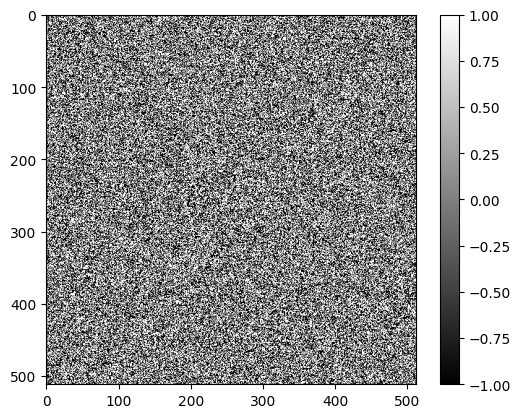

Starting warmup...
Starting trial iterations...
Completed 1/10000 iterations...
Completed 1001/10000 iterations...
Completed 2001/10000 iterations...
Completed 3001/10000 iterations...
Completed 4001/10000 iterations...
Completed 5001/10000 iterations...
Completed 6001/10000 iterations...
Completed 7001/10000 iterations...
Completed 8001/10000 iterations...
Completed 9001/10000 iterations...


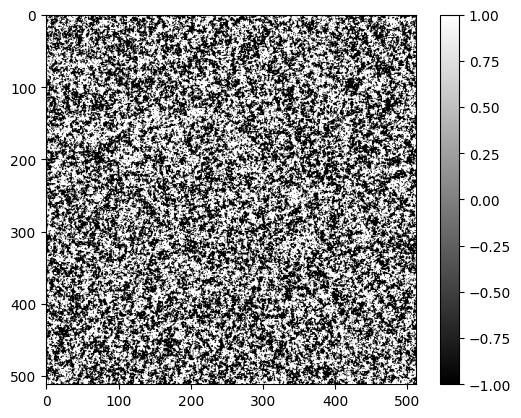

In [60]:
######### Start of the Simulation ############

# Set device
cuda.select_device(rank)

# Setup cuRAND generator
rng = curandUniformRNG(seed=seed if use_common_seed else seed + 42 * rank)
randvals = cuda.device_array((lattice_slab_n, lattice_m // 2), dtype=np.float32)

# Setup black and white lattice arrays on device
rng.fill_random(randvals)
lattice_b = generate_lattice(randvals)
rng.fill_random(randvals)
lattice_w = generate_lattice(randvals)

initial_lattice = combine_lattice(lattice_b, lattice_w).copy()
plot_ising(initial_lattice)

# Setup/open CUDA IPC handles
ipch_b = comm.allgather(lattice_b.get_ipc_handle())
ipch_w = comm.allgather(lattice_w.get_ipc_handle())
lattices_b = [x.open() if i != rank else lattice_b for i,x in enumerate(ipch_b)]
lattices_w = [x.open() if i != rank else lattice_w for i,x in enumerate(ipch_w)]

# Equilibration
if rank == 0:
    print("Starting warmup...")
    sys.stdout.flush()
sync()
for i in range(eq_steps):
    update(lattices_b, lattices_w, randvals, rng, inv_temp)
sync()

E1 = M1 = E2 = M2 = 0
# Start of calculation
if rank == 0:
    print("Starting trial iterations...")
    sys.stdout.flush()

for i in range(mc_steps):
    update(lattices_b, lattices_w, randvals, rng, inv_temp)
    if (rank == 0 and i % 1000 == 0):
        print("Completed {}/{} iterations...".format(i+1, mc_steps))
        sys.stdout.flush()
        
    Ene = calc_energy(lattices_b, lattices_w)
    Mag = comm.allreduce(calc_mag(lattices_b, lattices_w), MPI.SUM)

    E1 += Ene
    M1 += Mag
    M2 += Mag*Mag 
    E2 += Ene*Ene
sync()

E = n1*E1
M = n1*M1
C = (n1*E2 - n2*E1*E1)*inv_temp_sq
X = (n1*M2 - n2*M1*M1)*inv_temp

lattice = combine_lattice(lattices_b[rank], lattices_w[rank])
plot_ising(lattice)

# Formulas

## Hamiltonian
$$H = - J \sum_{\langle i j\rangle}s_i s_j - h \sum_i s_i$$
## Mean Internal Energy
$$\langle U \rangle = \frac{H}{2N}$$
$$\langle U\rangle = \frac{1}{2N}\left(- J \sum_{\langle i j\rangle}^N s_i s_j - h \sum_i^N s_i\right)$$
## Mean Magnetization
$$\langle M \rangle = \frac{1}{N}\sum_i^N s_i$$
## Absolute Mean Magnetization
$$\langle |M| \rangle = \bigg|\frac{1}{N}\sum_i^N s_i\bigg|$$
## Specific Heat per spin
$$\langle C\rangle = \frac{1}{k_B T^2} (\langle U^2\rangle - \langle U\rangle^2)$$
## Magnetic Susceptibility per spin
$$\langle \chi\rangle = \frac{1}{k_B T}(\langle M^2\rangle - \langle M^2\rangle)$$